# **Humpback whale tail based classification **

Since the data preprocessing/deep learning algorithm (CNN) requires a GPU for its execution, this project is done on Google Colab. The image files are initially uploaded into google drive (both test/train images). This is done since it would be easily accessible through colab by importing the google.colab library. 

**Google drive access**
---



The drive corresponding to the image folder needs an authorization to be given initally, before colab can access the same. 

In [0]:
from google.colab import drive
drive.mount('/content/Drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/Drive


**Exploratory Visualization**
---

The below graphical representation highlights the number of sample images available for different whale species. Below points can be inferred from the graphs/diagram. 



*   There are almost 10K 'new_whale' labels. These are the images without a predefined label. This would need to be removed before training.
*   There are also a lot of unequality between labels as there are few labels that have only 1 sample image rather few others have more than 70 samples. 







In [0]:
import pandas as pd
from os import listdir
from os.path import isfile, join

base_path = r'/content/Drive/My Drive/MachineLearningData/Kaggle_whale_tail/'

train_illustration = pd.read_csv(base_path + 'train.csv')
train_groupdata = train_illustration.groupby('Id').Image.nunique()
# len(xl[xl.Id != 'new_whale'])
# Print the initial 10 whale labels. It is pretty obvious that there are almost 10K new_whale labels. These are the uncategorized whale species. 
print(train_groupdata[:10])


Id
new_whale    9664
w_0003639       1
w_0003c59       1
w_0027efa      10
w_00289b1       2
w_002c810       1
w_0032a46       1
w_003bae6       8
w_00656c0       2
w_0066399       1
Name: Image, dtype: int64


There are obviously more new_whale categories than any other. 

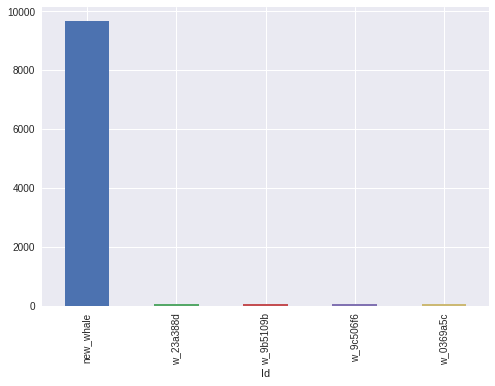

In [0]:
train_groupdata.sort_values(ascending=False).head().plot.bar()

Now let us drop the label 'new_whale'. We can notice that there are few labels with data samples as high as 70 and for a few its as low as 1 sample. 

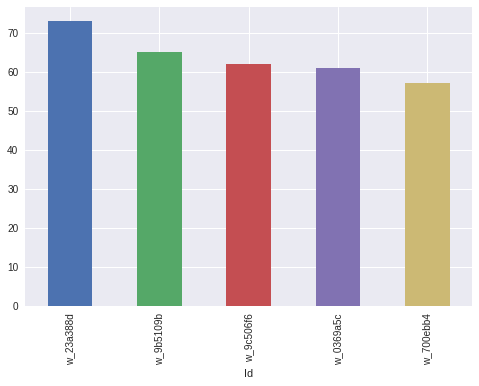

In [0]:
train_groupdata = train_groupdata.drop('new_whale')
train_groupdata.sort_values(ascending=False).head().plot.bar()

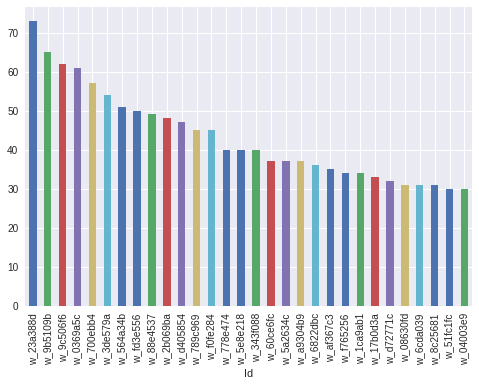

In [0]:
train_groupdata.sort_values(ascending=False).iloc[0:30].plot.bar()

In [0]:
train_groupdata[train_groupdata.sort_values(ascending=True) < 5].sort_values(ascending=False)
print('Total no of 1 : ', len(train_groupdata[train_groupdata.sort_values(ascending=True) == 1 ]))
print('Total no of 2 : ', len(train_groupdata[train_groupdata.sort_values(ascending=True) == 2 ]))
print('Total no of 3 : ', len(train_groupdata[train_groupdata.sort_values(ascending=True) == 3 ]))
print('Total no of 4 : ', len(train_groupdata[train_groupdata.sort_values(ascending=True) == 4 ]))
labels_greater_than_two = { x: 0 for x in train_groupdata[train_groupdata.sort_values(ascending=True) > 2].index.tolist()}
labels_equal_two = { x: 0 for x in train_groupdata[train_groupdata.sort_values(ascending=True) == 2].index.tolist()}
labels_equal_one = { x: 0 for x in train_groupdata[train_groupdata.sort_values(ascending=True) == 1].index.tolist()}



Total no of 1 :  2073
Total no of 2 :  1285
Total no of 3 :  568
Total no of 4 :  273


# Data Augmentation
To introduce a bit of equal distribution between the various labels the labels with fewer samples are passed throught the augmentation pipleline where the image vector would be rotated, zoomed, sheared or even flipped horizontally.

In [0]:
import sys
from collections import Counter
import random
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import skimage.filters


from sklearn.model_selection import train_test_split

from keras.preprocessing.image import (
    random_rotation, random_shift, random_shear, random_zoom,
    random_channel_shift, img_to_array)

%matplotlib inline

In [0]:
def plot_image(imgs, labels, rows):
  figure = plt.figure(figsize = (13, 8))
  cols = len(imgs) // rows + 1
  
  for i in range(len(imgs)):
    subplot = figure.add_subplot(rows, cols, i+1)
    subplot.axis('Off')
    if labels:
      subplot.set_title(labels[i], fontsize=16)
    plt.imshow(imgs[i], cmap='gray')

def random_greyscale(img, p):
    if len(img.shape) == 2 or img.shape[2] == 1:
        return np.repeat(img[:, :, np.newaxis], 3, axis=2)
    
    if random.random() < p:
        return np.dot(img[...,:3], [0.299, 0.587, 0.114])
    return img

def random_flip(img, p):
    if random.random() < p:
        return np.flip(img, 1)
    return img

def random_blur(img, p, sigma=1.37):
    if random.random() < p:
        return skimage.filters.gaussian(img / 255.0, sigma=sigma, multichannel=len(img.shape) == 3) * 255
    return img

def augmentation_pipeline(img_arr):
    img_arr = random_rotation(img_arr, 18, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_shear(img_arr, intensity=0.4, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_zoom(img_arr, zoom_range=(0.7, 1.4), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest') # we do not want to zoom out, as the net may learn the artifacts caused by the filled areas.
    # img_arr = random_greyscale(img_arr, 0.2)
    # img_arr = random_blur(img_arr, 0.33)
    img_arr = random_flip(img_arr, 0.5)
    return np.expand_dims(img_arr, axis = 0)


Each of the image would be reduced to a size of (160, 120). These are then augmented and trained.

In [0]:
image_size = (160,120) # width, height
no_of_augmentation = 0
path = r'/content/Drive/My Drive/MachineLearningData/Kaggle_whale_tail/train/'            
def loadImageAndAugument(imgPath, label, imageSize = image_size, numOfAugumentations = no_of_augmentation ):
    
    if label in labels_greater_than_two:
      if labels_greater_than_two[label] > 3:
        return []
      else:
        numOfAugumentations = 0
        labels_greater_than_two[label] += 1
    elif label in labels_equal_two:
      numOfAugumentations = 1
    else:
      numOfAugumentations = 4
    imgPath = path + imgPath
    inputImage = Image.open(imgPath).resize(imageSize).convert('RGB')
    result = []
    inputImageArray = img_to_array(inputImage)
    result.append(np.asarray([inputImageArray / 255]))
    for i in range(numOfAugumentations):
        result.append(augmentation_pipeline(inputImageArray) / 255)
    return result

def loadImageValidation(imgPath, imageSize = image_size, numOfAugumentations = no_of_augmentation):
    imgPath = path + imgPath
    inputImage = Image.open(imgPath).resize(imageSize).convert('RGB')
    inputImageArray = img_to_array(inputImage)
    result = []
    result.append(np.asarray([inputImageArray / 255]))
    return result
  
def loadBatchValidation(imagePaths, labels, startIdx=0, numOfImages=None):
    if numOfImages is None:
        numOfImages = int(imagePaths.count() - startIdx)
    loadedLabels = []
    loadedImages = []
    for index, imgPath in itertools.islice(imagePaths.iteritems(), startIdx, min(startIdx+numOfImages, imagePaths.count())):
        # print(index, imgPath)
        imgArrays = loadImageValidation(imgPath)
        for img in imgArrays:
            loadedLabels.append(labels[index])
            loadedImages.append(img)
    return (loadedImages, loadedLabels)
  
def loadBatch(imagePaths, labels, startIdx=0, numOfImages=None, toggle = None):
    if numOfImages is None:
        numOfImages = int(imagePaths.count() - startIdx)
    if toggle is not None:
      if(toggle%2 == 0): 
        no_of_augmentation = 1
      else: 
        no_of_augmentation = 0
    loadedLabels = []
    loadedImages = []
    for index, imgPath in itertools.islice(imagePaths.iteritems(), startIdx, min(startIdx+numOfImages, imagePaths.count())):
        # print(index, imgPath)
        imgArrays = loadImageAndAugument(imgPath,  label = labels[index], numOfAugumentations= no_of_augmentation)
        for img in imgArrays:
            loadedLabels.append(labels[index])
            loadedImages.append(img)
    return (loadedImages, loadedLabels)

def laodAndPrepareDataset(datasetPath, train_size=0.8, random_state=None):
    if random_state is None:
        random_state = random.randrange(2**32 - 1)
    # load data to Panda DataFrame
    train_df = pd.read_csv(datasetPath)
    train_df = train_df[train_df.Id != 'new_whale']
    # Make things unique
    return train_test_split(train_df['Image'], 
                             train_df['Id'],
                             train_size=train_size, 
                             test_size=1.0 - train_size,
                             random_state=random_state)

# Image Extraction 

The training data set and the validation dataset are split are split in the ratio of 4:1. They are extracted from the train.csv file.

In [0]:
x_train_path, x_valid_path, x_train_label, y_valid_label = laodAndPrepareDataset(r'/content/Drive/My Drive/MachineLearningData/Kaggle_whale_tail/train.csv')

In [0]:
import os

class train_stag:
  def __init__(self):
    self.train_staging_img = []
    self.train_staging_lab = []
  def __enter__(self):
    return self
  def __exit__(self, type, value, traceback):
    pass

In [0]:
labels_greater_than_two = { x: 0 for x in train_groupdata[train_groupdata.sort_values(ascending=True) > 2].index.tolist()}
labels_equal_two = { x: 0 for x in train_groupdata[train_groupdata.sort_values(ascending=True) == 2].index.tolist()}
labels_equal_one = { x: 0 for x in train_groupdata[train_groupdata.sort_values(ascending=True) == 1].index.tolist()}

from datetime import datetime
tstart = datetime.now()

train_aug_img_final = []
train_aug_val_final = []

with train_stag() as ml:
  for i in range(0, 126):
    idx = int(i*100)
    train_aug_img_temp = None
    train_aug_lab_temp = None
    if(i!=125):
      train_aug_img_temp, train_aug_lab_temp = loadBatch(x_train_path, x_train_label, idx, 100, i)
    else:
      train_aug_img_temp, train_aug_lab_temp = loadBatch(x_train_path, x_train_label, idx, None, i)
    if len(train_aug_lab_temp):
      ml.train_staging_img += train_aug_img_temp
      ml.train_staging_lab += train_aug_lab_temp
    
    if((i+1)%10 == 0):
      print(i+1, 'Batch Done', len(ml.train_staging_img))
  train_aug_img_final = np.vstack(ml.train_staging_img)
  train_aug_val_final = ml.train_staging_lab

tend = datetime.now()
print('Time Taken to retrieve data', tend - tstart)

10 Batch Done 1773
20 Batch Done 3415
30 Batch Done 4960
40 Batch Done 6432
50 Batch Done 7912
60 Batch Done 9316
70 Batch Done 10723
80 Batch Done 12028
90 Batch Done 13362
100 Batch Done 14722
110 Batch Done 15970
120 Batch Done 17160
Time Taken to retrieve data 0:42:54.399960


In [0]:
print('No of training data samples before data augmentation :', len(x_train_path), '\n', 'No of Validation data samples before data augmentation:', len(x_valid_path))
print('No of training data samples after data augmentation :', len(train_aug_val_final))
print('Shape of the training vector :', train_aug_img_final.shape)

No of training data samples before data augmentation : 12557 
 No of Validation data samples before data augmentation: 3140
No of training data samples after data augmentation : 17769
Shape of the training vector : (17769, 120, 160, 3)


In [0]:
# Validation data
tstart = datetime.now()
train_val_img_final = []
train_val_lab_final = []
with train_stag() as ml_valid:
  for i in range(0, 32):
    train_val_img_stag = []
    train_val_lab_stag = []
    if(i != 31):
      train_val_img_stag, train_val_lab_stag = loadBatchValidation(x_valid_path, y_valid_label,int(i*100), 100)
    else:
      train_val_img_stag, train_val_lab_stag = loadBatchValidation(x_valid_path, y_valid_label,int(i*100), None)
    ml_valid.train_staging_img += train_val_img_stag
    ml_valid.train_staging_lab += train_val_lab_stag
    if((i+1)%10 == 0):
      print(i+1, 'Validation Batch Done!', 'Batch size', len(ml_valid.train_staging_img))
  train_val_img_final = np.vstack(ml_valid.train_staging_img)
  train_val_lab_final = ml_valid.train_staging_lab

tend = datetime.now()
print('Time Taken to retrieve data', tend - tstart)

10 Validation Batch Done! Batch size 1000
20 Validation Batch Done! Batch size 2000
30 Validation Batch Done! Batch size 3000
Time Taken to retrieve data 0:15:42.702954


In [0]:
print('No of validation data samples after data augmentation :', len(train_val_img_final))
print('Shape of the training vector :', train_val_img_final.shape)

No of validation data samples after data augmentation : 3140
Shape of the training vector : (3140, 120, 160, 3)


In [0]:
# appending both val and train labels to gen the one-hot encoding
tot_train_dummy = train_aug_val_final + train_val_lab_final
train_dummy_final = pd.get_dummies(pd.Series(tot_train_dummy)).values[:len(train_aug_val_final)]
validation_dummy_final = pd.get_dummies(pd.Series(tot_train_dummy)).values[len(train_aug_val_final):]

In [0]:
print('Total unique labels', len(set(tot_train_dummy)))

Total unique labels 5004


# Model Training

The pretrained VGG16 model is first loaded to ensure that we are using transfer learning to train our model.


In [0]:
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers

vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(120, 160, 3))

layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block4_pool'].output


# Stacking a new simple convolutional network on top of it    
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(train_dummy_final.shape[1], activation='softmax')(x)


from keras.models import Model
custom_model = Model(input=vgg_model.input, output=x)

# Make sure that the pre-trained bottom layers are not trainable
for layer in custom_model.layers[:8]:                               
    layer.trainable = True

for layer in custom_model.layers[8:15]:                               
    layer.trainable = False

# Do not forget to compile it.. change it back to rmsprop
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adm = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
custom_model.compile(loss='categorical_crossentropy',
                     optimizer=sgd,
                     metrics=['accuracy'])

custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 120, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 40, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
from keras.callbacks import ModelCheckpoint  

epochs = 10

checkpointer = ModelCheckpoint(filepath=r'/content/Drive/My Drive/MachineLearningData/Kaggle_whale_tail/weights.best.from_scratch_sgd_ph4.hdf5', 
                               verbose=1, save_best_only=True)
### TODO: specify the number of epochs that you would like to use to train the model.
for i in range(0, 4):
  print('Commencing phase :', i+1)
  custom_model.fit(train_aug_img_final, train_dummy_final, 
            validation_data=(train_val_img_final, validation_dummy_final),
            epochs=epochs, batch_size=25, callbacks=[checkpointer], verbose=1)
  custom_model.load_weights(r'/content/Drive/My Drive/MachineLearningData/Kaggle_whale_tail/weights.best.from_scratch_sgd_ph4.hdf5')
  print('Phase', i+1,' complete!')

Commencing phase : 1
Instructions for updating:
Use tf.cast instead.
Train on 17769 samples, validate on 3140 samples
Epoch 1/10
17769/17769 [==============================] - 201s 11ms/step - loss: 3.8148 - acc: 0.2867 - val_loss: 2.2377 - val_acc: 0.6080

Epoch 00001: val_loss improved from inf to 2.23770, saving model to /content/Drive/My Drive/MachineLearningData/Kaggle_whale_tail/weights.best.from_scratch_sgd_ph4.hdf5
Epoch 2/10
17769/17769 [==============================] - 191s 11ms/step - loss: 3.6147 - acc: 0.3046 - val_loss: 2.2811 - val_acc: 0.5908

Epoch 00002: val_loss did not improve from 2.23770
Epoch 3/10
17769/17769 [==============================] - 191s 11ms/step - loss: 3.4412 - acc: 0.3297 - val_loss: 2.3022 - val_acc: 0.5710

Epoch 00003: val_loss did not improve from 2.23770
Epoch 4/10
17769/17769 [==============================] - 191s 11ms/step - loss: 3.2913 - acc: 0.3504 - val_loss: 2.3682 - val_acc: 0.5525

Epoch 00004: val_loss did not improve from 2.23770


In [0]:
custom_model.load_weights(r'/content/Drive/My Drive/MachineLearningData/Kaggle_whale_tail/weights.best.from_scratch_sgd_ph5.hdf5')

VGG16_predictions = [np.argmax(custom_model.predict(np.expand_dims(feature, axis=0))) for feature in train_val_img_final]
test_accuracy = 100*np.sum(np.array(VGG16_predictions) == np.argmax(validation_dummy_final, axis=1))/len(VGG16_predictions)
print('Accuracy: %.4f%%' % test_accuracy)

Accuracy: 60.7962%


In [0]:
VGG16_predictions = [np.asarray(custom_model.predict(np.expand_dims(feature, axis=0)))[0].argsort()[-5:][::-1] for feature in train_val_img_final]
print('Accuracy on taking first 5 best suggestions based on the softmax function :', sum([y in x for x, y in zip(VGG16_predictions, np.argmax(validation_dummy_final, axis =1 ))])/len(VGG16_predictions)*100)

Accuracy on taking first 5 best suggestions based on the softmax function : 78.0891719745223
